In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## FIFA dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

## Cuda

In [3]:
torch.cuda.is_available()

False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## utils functions

In [5]:
print(fn_plot_torch_hist.__doc__)

None


In [6]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


## basic parameters

In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

EPOCHS = 51 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read FIFA 2019 data set

### dataset loading and cleaning

In [8]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [9]:
for col in data_df.columns:
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [10]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Target = positions 

In [12]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

### Keeping relevant columns
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
# splitting in train and test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )

train_df.shape, test_df.shape

((14517, 34), (3630, 34))

## Scalling and feature labels extraction  

In [15]:
## using singleton design pattern

class GlobalScaler:
    _instance = None
    
    def __init__(self):
        if GlobalScaler._instance is not None:
            raise Exception ("GloalScaler class is singleton")
        self.scaler = StandardScaler()
            
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScaler()
        return cls._instance


In [16]:
class FifaDS(Dataset):
    globalScaler = GlobalScaler.get_instance()
    
    def __init__(self, dataframe : pd.DataFrame,
                device: str = device, is_train =True, 
                label_col = None):
        self.df = dataframe
        self.device = device
        self.scaler = self.globalScaler.scaler
        self.is_train = is_train
        self.label_col = label_col
        
        self.labels = self.df[label_col].to_numpy()
        X = self.df.drop(label_col , axis =1)
        
        if self.is_train:
            self.features = self.scaler.fit_transform(X)
        else:
            self.features = self.scaler.transform(X)
         
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        features = self.features[idx]
        label = self.labels[idx]
            
        features = torch.tensor(features, dtype=torch.float32,device = self.device)
        label = torch.tensor(label, dtype=torch.int64,device = self.device)
        return features, label

In [17]:
label_col = 'Position'

train_ds = FifaDS(train_df, is_train = True, label_col=label_col)

test_ds = FifaDS(test_df, is_train = False, label_col=label_col)

In [18]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184]),
 tensor(3))

In [19]:
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True)

## Model

In [20]:
input_shape = train_df.shape[1]-1
input_shape

33

In [21]:
class Model (nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,18)
        self.activ1 = nn.SiLU()
        self.layer2 = nn.Linear(18,4)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = F.softmax(self.layer2(x),dim =1)
        return x

net = Model(input_dim = input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (activ1): SiLU()
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


## Traing and testing

In [22]:
## Loss function
loss_fn = nn.CrossEntropyLoss()

## Optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=ALPHA)

### Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

## iterations
for epoch in range(EPOCHS):
    
    train_loss = 0.0
    train_acc = 0.0
    
    for i, (data, target) in enumerate(train_loader):
    
        net.train() ### set model in training mode
    
        predict_prob = net(data) ## make prediction
    
        curr_loss = loss_fn(predict_prob , target) ## Calculate loss
    
        ### -----------
        ### Back Prop Step
        ### -----------
    
        optimizer.zero_grad() ### forget gradients for previous loop
        curr_loss.backward() ## asssign loss calculated
        optimizer.step() ## calculate gradients and take step to reduce loss
    
        train_loss += curr_loss.data.item()  # append to loss list
    
        _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
        curr_acc = accuracy_score( target, y_pred.data) # move to CPU if  device = 'cpu' --> y_pred.data.cpu()
    
        train_acc += curr_acc  # append to accuracy list
        
        num_batch_train = i
    
    test_loss = 0.0
    test_acc = 0.0
    
    for i, (data, target) in enumerate(test_loader):
        
        net.eval() # evaluation mode, prevent from learning
    
        predict_prob_tst = net(data) # make predictions on test data
    
        tcurr_loss = loss_fn( predict_prob_tst, target)
    
        test_loss += tcurr_loss.data.item()  # append to loss list
    
        _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
        tcurr_acc = accuracy_score( target, y_pred.data.cpu())# move to CPU 
    
        test_acc += tcurr_acc # append to accuracy list3
        
        num_batch_test = i
    
    n_epoch.append(epoch)
    loss.append(train_loss/num_batch_train)
    tloss.append(test_loss/num_batch_test)
    acc.append(train_acc/num_batch_train)
    tacc.append(test_acc/num_batch_test)  
    
    if epoch % 10 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             train_loss/num_batch_train,
                             test_loss/num_batch_test,  
                             train_acc/num_batch_train, 
                             test_acc/num_batch_test))

Epoch :    0/   51 --- Loss: 1.02451/0.92882 | Acc 0.77683/0.83905
Epoch :   10/   51 --- Loss: 0.86452/0.87772 | Acc 0.88476/0.87769
Epoch :   20/   51 --- Loss: 0.85961/0.87668 | Acc 0.88876/0.88081
Epoch :   30/   51 --- Loss: 0.85640/0.87281 | Acc 0.89151/0.88460
Epoch :   40/   51 --- Loss: 0.85470/0.87184 | Acc 0.89317/0.88535
Epoch :   50/   51 --- Loss: 0.85364/0.87329 | Acc 0.89368/0.88215


## Visualization of model metrics

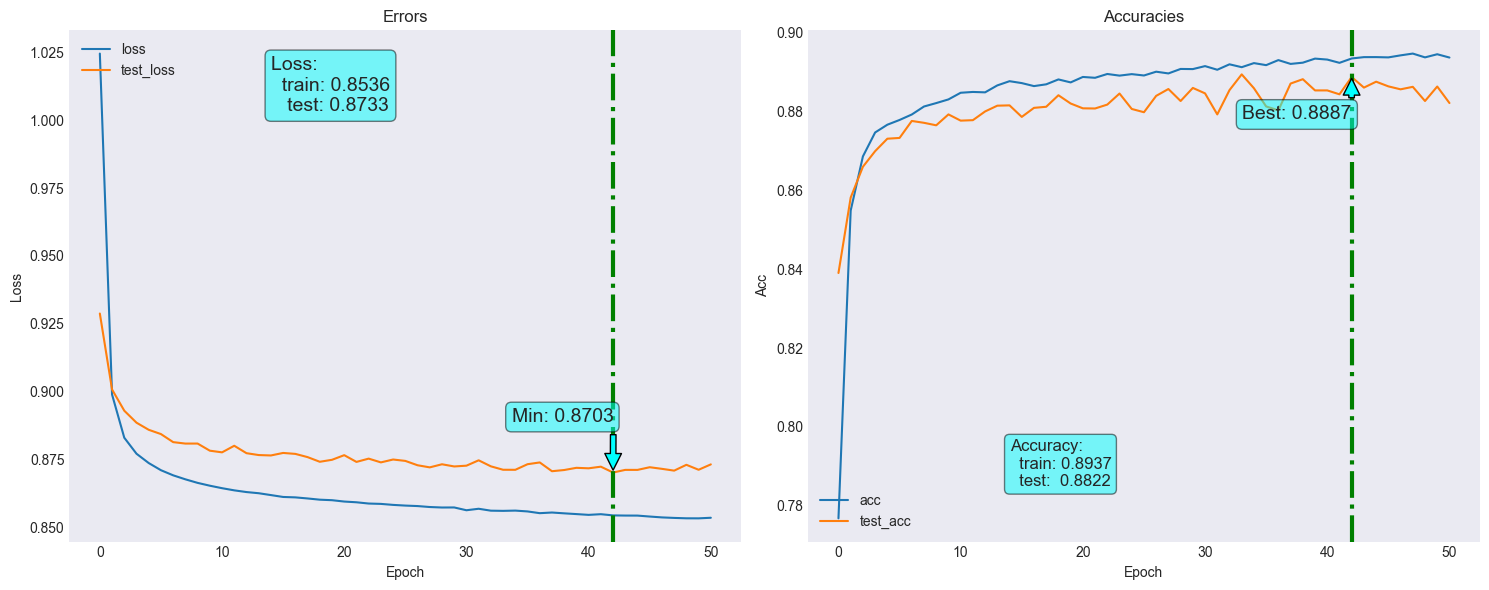

In [23]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})
fn_plot_torch_hist(loss_df)

## Training Confusion matrics

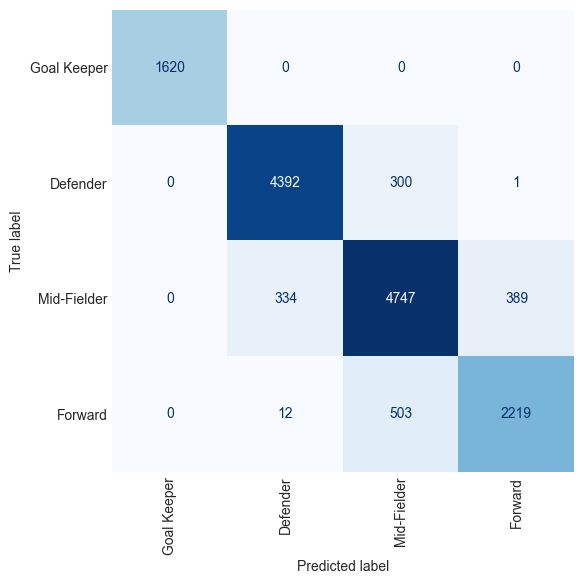

In [27]:
y_train = []
y_pred = []

for i, (data,target) in enumerate (train_loader):
    outputs = net(data)
    pred = torch.argmax(outputs, dim=1)
    y_train.extend(target.numpy())
    y_pred.extend(pred.numpy())
fn_plot_confusion_matrix(y_train, y_pred, labels=labels)

## Testing Confusion matrics

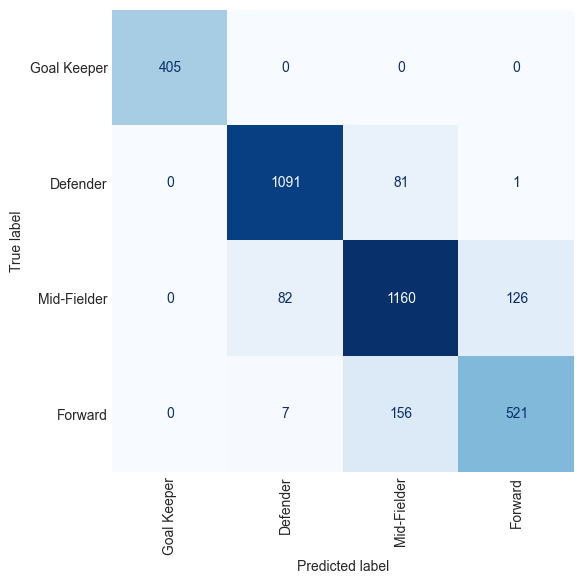

In [29]:
y_test = []
y_pred = []

for i, (data,target) in enumerate (test_loader):
    outputs = net(data)
    pred = torch.argmax(outputs, dim=1)
    y_test.extend(target.numpy())
    y_pred.extend(pred.numpy())
fn_plot_confusion_matrix(y_test, y_pred, labels=labels)